# Precursors
The current iteration of this pipeline is coded to work only for FER2013  
Plans include room for RAFDB, CK+ and other models

##### Import packages


In [59]:
import torch
import ipykernel
import numpy as np
import pandas
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image
import timm
print("Pytorch version: ",torch.__version__)
print("Numpy version: ",np.__version__)
print("Jupyter notebook version: ",ipykernel.__version__)
print("Timm version: ",timm.__version__)

Pytorch version:  2.5.1
Numpy version:  2.2.5
Jupyter notebook version:  7.1.0
Timm version:  1.0.22


#### 1. Import data and wrap around dataloaders

##### Create FERDataset Class to store datasets

In [ ]:
"""
FERDataset
A class which inherits the pytorch dataset for storing and manipulating our input
"""
# Inherits Pytorch dataset
class FERDataset(Dataset):
    def __init__(self, dataframe, transform = None):
        # Constructor
        # (String) df: Instance of pandas dataframe with data already loaded
        # (Function) transform: Image processing function 
        
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        row = self.df.iloc[idx]

        pixels = np.fromstring(row['pixels'], sep=' ', dtype=np.uint8)
        img = pixels.reshape(48, 48) #48x48 to match FER2013

        # from greyscale to RGB
        img = Image.fromarray(img).convert("RGB")

        label = int(row['emotion'])

        # transform img
        if self.transform:
            img = self.transform(img)

        return img, label

    @property
    def classes(self):
        classes = self.df['emotion'].unique()
        classes.sort()
        return classes
    


##### Load and test the dataset (FER2013)

In [61]:
fer2013_dataframe = pandas.read_csv('C:\\Users\\Bahram\\Desktop\\Personal Projects\\FER Tinkering\\From_Scratch\\data\\FER2013\\fer2013.csv')
dataset = FERDataset(dataframe=fer2013_dataframe)
dataset.classes
# Should be seven classes for FER2013

array([0, 1, 2, 3, 4, 5, 6])

##### Class dictionary

In [62]:
emotion_names = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral"
}

##### Grab an image and check its emotion

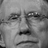

In [63]:
image, label = dataset[123]
image

In [64]:
emotion_names[label]

'Angry'

### I don't think he looks angry, but moving on

##### 2. Transform each image and recreate the dataset using the transform

In [67]:
transform = transforms.Compose([
    transforms.Resize((48,48)),
    transforms.ToTensor(),
])
dataset = FERDataset(fer2013_dataframe, transform)

In [ ]:
image, label = dataset[0]
image.shape # Three channels, 48x48 image

torch.Size([3, 48, 48])

##### Dataloaders  
For batching our dataset

In [71]:
batch_size = 32
dataloader = DataLoader(dataset,batch_size, shuffle=True)